**Aims**:
 - extract the omics mentioned in multi-omics articles

In [1]:
%run notebook_setup.ipynb

In [2]:
import pandas
pandas.set_option('display.max_colwidth', 100)

In [3]:
%vault from pubmed_derived_data import literature

Imported `literature` (E4FB4141) at Wednesday, 22. Jul 2020 21:30

In [4]:
has_abstract = ~literature['abstract'].isnull()

**TODO: use title if not abstract, add keywords, use full text if available**

In [5]:
literature['abstract_clean'] = literature['abstract_clean'].fillna('')

In [6]:
omics_features = literature.index.to_frame().copy()

In [7]:
from functools import partial
from helpers.text_processing import check_usage
from pandas import Series

check_usage_in_abstracts = partial(check_usage, data=literature, column='abstract_clean')

In [8]:
TERM_IN_AT_LEAST_N_ARTICLES = 5

# Omics

In [9]:
from re import findall

Anythings that ends with -ome

In [10]:
note_an_ome = {
    'outcome',
    'some',
    'become',
    'home',
    'come',
    'chromosome',
    'overcome',
    'cytochrome',
    'ribosome',
    'syndrome'
}

In [11]:
ome_re = (
    # use look-ahead to allow for overlaps
    '(?='
        r'(?:^|\s)(\S+ome)(?:\s|$)'
    ')'
)

In [12]:
assert findall(ome_re, 'genome') == ['genome']
assert findall(ome_re, 'genome proteome') == ['genome', 'proteome']

In [13]:
ome_occurrences = (
    literature['abstract_clean'].str.lower()
    .str.extractall(ome_re)[0]
    .to_frame('term').reset_index()
)
ome_occurrences = ome_occurrences[~ome_occurrences.term.isin(note_an_ome)]
ome_occurrences.head(3)

,uid,match,term
5,16611894,0,genome
7,16935752,0,genome
9,17420480,0,transcriptome


In [14]:
ome_counts = ome_occurrences.drop_duplicates(['uid', 'term']).term.sorted_value_counts()
ome_counts[ome_counts > TERM_IN_AT_LEAST_N_ARTICLES]

index
genome                 437
transcriptome          264
proteome               195
microbiome             169
metabolome             145
whole-genome            47
exome                   42
epigenome               26
methylome               26
whole-exome             22
interactome             17
metagenome              15
phosphoproteome         15
secretome               12
lipidome                10
translatome              7
whole-transcriptome      7
metatranscriptome        6
peroxisome               6
phenome                  6
proteasome               6
Name: term, dtype: int64

In [15]:
from re import escape

In [16]:
separators = {'/', '"', "'", '-'}
separators_re = '|'.join([escape(s) for s in separators])
omics_re = (
    # use look-ahead to allow for overlaps
    '(?='
        rf'(?:^|\s|{separators_re})'
        # match '*-omic', '*-*omic', '*omic'
        '('
            # handle both *omic-*omic and *-*omic
            r'(?:\w+)omic'
            '|'
            '(?:(?:\w+-\w*)|\w+)omic'
        ')'
        # match both *omic and omics, but capture only "omic" part
        '(?:s)?'
        rf'(?:\s|$|{separators_re})'
    ')'
)

In [17]:
assert findall(omics_re, 'omic') == []
assert findall(omics_re, 'genomics') == ['genomic']
assert findall(omics_re, ' genomics') == ['genomic']
assert findall(omics_re, 'genomics ') == ['genomic']
assert findall(omics_re, ' genomics ') == ['genomic']

In [18]:
assert findall(omics_re, 'prote-omic') == ['prote-omic']
assert findall(omics_re, 'prote-omics') == ['prote-omic']

In [19]:
assert findall(omics_re, 'transcriptomic proteomic') == ['transcriptomic', 'proteomic']
assert findall(omics_re, 'transcriptomic-proteomic') == ['transcriptomic', 'proteomic']

In [20]:
assert findall(omics_re, 'transcriptomic proteomic') == ['transcriptomic', 'proteomic']
assert list(Series(['transcriptomic proteomic']).str.extractall(omics_re)[0]) == ['transcriptomic', 'proteomic']

In [21]:
check_usage_in_abstracts('integromics')

uid
23105932    endium and integrative omics analyses, so-called "integromics", have extended our understanding ...
24299457    rmacological response mechanisms. By means of an "integromics" network approach, we assessed the...
25887273                                  \nThe avalanche of integromics and panomics approaches shifted the de
27255914    l explore the essential elements of assembling an integromics framework from a more detailed per...
31126983    on of these orthogonal data sets, perhaps called "integromics." We highlight examples of recent ...
Name: abstract_clean, dtype: object

In [22]:
check_usage_in_abstracts('meta-omics')

uid
19837627    s on metabolomics data management, normalization, meta-omics data analysis, and an integrative a...
26315987    nd us through the application of high-resolution "meta-omics". Metaproteomics offers the ability...
28744486    odontal ligament and alveolar bone. We employed a meta-omics approach that included microbial 16...
29427518    ast few years, the application of high-throughput meta-omics methods has provided great progress...
29656009    enomics, transcriptomics, proteomics metabolomics meta-omics and combined omics as powerful stra...
30285475    per reviews studies in which application of these meta-omics technologies has led to a better un...
30728080    onomas sp. alone.\n\n\nThe three types of integrated meta-omics analyses effectively revealed th...
30945796    oding data sets were integrated in a multivariate meta-omics analysis (multi-block PLS-DA from t...
31186307    niches of constituent populations, and functional meta-omics becomes a proxy to characte

In [23]:
multi_omic = {
    'multi-omic',
    'multiomic',
    'cross-omic',
    'panomic',
    'pan-omic',
    'trans-omic',
    'transomic',
    'four-omic',
    'multiple-omic',
    'inter-omic',
    'poly-omic',
    'polyomic',
    'integromic'
}

tools = {
    # MixOmics
    'mixomic'
}

vague = {
    'single-omic'
}

adjectives = {
    'economic',
    'socio-economic',
    'socioeconomic',
    'taxonomic',
    'syndromic',
}

not_an_omic = {
    *adjectives,
    *multi_omic,
    *tools,
    *vague
}

In [24]:
omic_occurrences = (
    literature['abstract_clean'].str.lower()
    .str.extractall(omics_re)[0]
    .to_frame('term').reset_index()
)
omic_occurrences = omic_occurrences[~omic_occurrences.term.isin(not_an_omic)]
omic_occurrences.head(2)

,uid,match,term
1,15687839,0,proteomic
2,15687839,1,proteomic


In [25]:
omic_counts = omic_occurrences.drop_duplicates(['uid', 'term']).term.sorted_value_counts()
omic_counts[omic_counts > TERM_IN_AT_LEAST_N_ARTICLES].add_suffix('s')

index
genomics               538
proteomics             538
transcriptomics        423
metabolomics           412
metagenomics            88
epigenomics             76
lipidomics              52
proteogenomics          35
phosphoproteomics       27
metaproteomics          26
pharmacogenomics        25
metatranscriptomics     23
phenomics               19
glycomics               14
post-genomics           14
radiomics               13
meta-omics              12
fluxomics               11
metabonomics            11
peptidomics             10
postgenomics            10
methylomics              9
agronomics               7
microbiomics             6
Name: term, dtype: int64

## Fields of study

In [26]:
'genetics', 'epigenetics'

('genetics', 'epigenetics')

Some authors may prefer to say "we integrated genetic and proteomic data" rather than "genomic and proteomic"

### Crude overview

In [27]:
ome_terms = Series(ome_counts[ome_counts > TERM_IN_AT_LEAST_N_ARTICLES].index)
omic_terms = Series(omic_counts[omic_counts > TERM_IN_AT_LEAST_N_ARTICLES].index)

In [28]:
assert omics_features.index.name == 'uid'

for term in ome_terms:
    mentioned_by_uid = set(ome_occurrences[ome_occurrences.term == term].uid)
    omics_features['mentions_' + term] = omics_features.index.isin(mentioned_by_uid)

for term in omic_terms:
    mentioned_by_uid = set(omic_occurrences[omic_occurrences.term == term].uid)
    omics_features['mentions_' + term] = omics_features.index.isin(mentioned_by_uid)

In [29]:
ome_terms_mentioned = omics_features['mentions_' + ome_terms].rename(columns=lambda x: x.replace('mentions_', ''))
omic_terms_mentioned = omics_features['mentions_' + omic_terms].rename(columns=lambda x: x.replace('mentions_', ''))

In [30]:
%R library(ComplexUpset);

[1] "Dropping 12 empty groups"


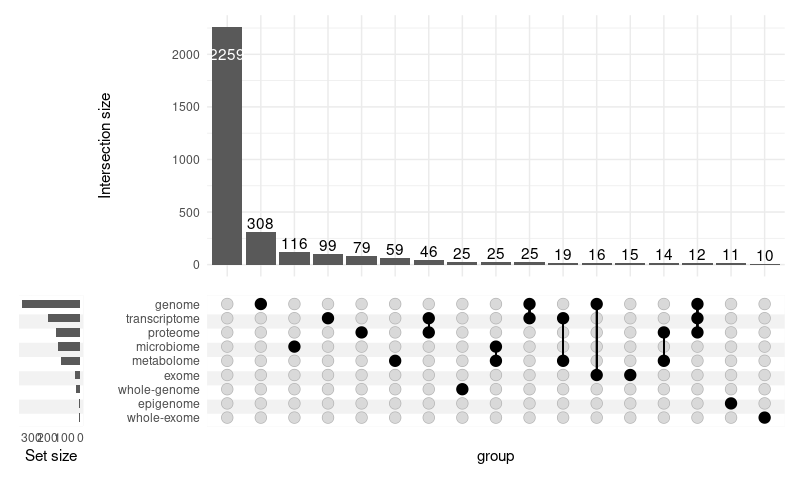

In [31]:
%%R -i ome_terms_mentioned -w 800 -r 100

upset(ome_terms_mentioned, colnames(ome_terms_mentioned), min_size=10, width_ratio=0.1)

[1] "Dropping 16 empty groups"


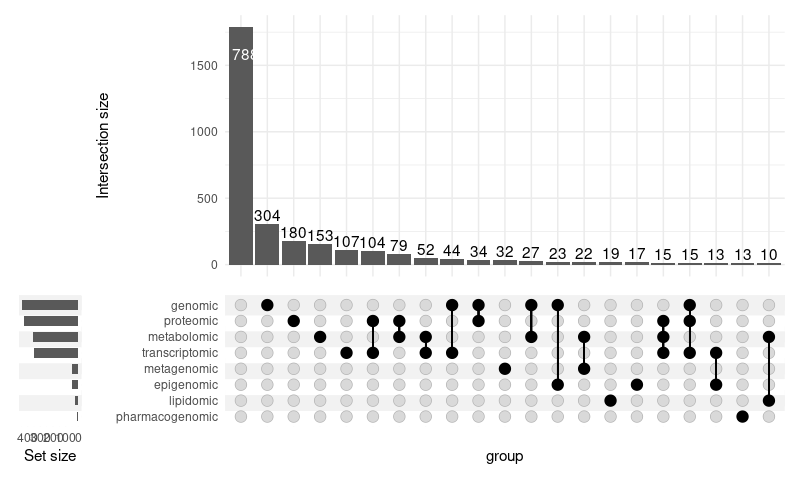

In [32]:
%%R -i omic_terms_mentioned -w 800 -r 100

upset(omic_terms_mentioned, colnames(omic_terms_mentioned), min_size=10, width_ratio=0.1)

## Merge -ome and -omic terms

In [33]:
terms_to_omics = {
    'genome': ['genomic'],
    'transcriptome': ['transcriptomic'],
    # ''
}